# Training YOLO Models in Google Colab
**Author:** Utkarsh Saxena

# Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11, YOLOv8, or YOLOv5 object detection models with a custom dataset.



**Verify NVIDIA GPU Availability**

Verify that the NVIDIA GPU is present and ready for training.

In [1]:
!nvidia-smi

Fri Sep 19 13:47:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#&nbsp; Dataset

I am using a ready made dataset here, it contains:

- An `images` folder containing the images
- A `labels` folder containing the labels in YOLO annotation format
- A `classes.txt` labelmap file that contains all the classes


Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## Spliting images into train and validation folders

 Next, we'll unzip `data.zip` and create some folders to hold the images. Run the following code block to unzip the data.

In [2]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.


I wrote a Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.

In [3]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-09-19 13:58:08--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-09-19 13:58:08 (44.8 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 750
Number of annotation files: 750
Images moving to train: 675
Images moving to validation: 75


# &nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.5 MB/s eta 0:00:00


# &nbsp;Configure Training


We need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available [here](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

this code block automatically generates a `data.yaml` configuration file.

In [5]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 4
names:
- penny
- nickel
- dime
- quarter


# &nbsp;Training Model

## Training Parameters
Training Setup

For training, I used the following key parameters:

Model architecture: yolo11s.pt (a small but efficient YOLO model that balances accuracy and speed).

Epochs: Trained for 60 epochs (based on dataset size).

Image resolution: Used 640x640 pixels, the standard YOLO training resolution.

These parameters provided good results for my dataset of coin images.


## Run Training!

Running code block to begin training.

In [6]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj

Training Process

The model was trained using the prepared training and validation sets.

During each epoch, the model’s performance was evaluated on the validation set, with metrics such as mAP (mean Average Precision), precision, and recall being tracked.

The best model weights were automatically saved in runs/detect/train/weights/best.pt.

Training logs and plots (loss, precision, recall, mAP) were also saved in the runs/detect/train/ folder for review.

#&nbsp;Testing Model

The trained model was tested on validation images to evaluate detection performance. Predictions were generated and visualized for a sample of images to confirm that the model correctly identified and classified objects.

In [7]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/75 /content/data/validation/images/IMG_3410.JPG: 640x480 1 penny, 1 nickel, 51.1ms
image 2/75 /content/data/validation/images/IMG_3416.JPG: 640x480 1 nickel, 2 quarters, 12.3ms
image 3/75 /content/data/validation/images/IMG_3424.JPG: 640x480 2 nickels, 1 quarter, 12.3ms
image 4/75 /content/data/validation/images/IMG_3456.JPG: 640x480 1 penny, 1 nickel, 1 quarter, 12.3ms
image 5/75 /content/data/validation/images/IMG_3457.JPG: 640x480 1 penny, 1 quarter, 12.3ms
image 6/75 /content/data/validation/images/IMG_3461.JPG: 640x480 2 pennys, 1 nickel, 12.3ms
image 7/75 /content/data/validation/images/IMG_3462.JPG: 640x480 1 dime, 2 quarters, 12.3ms
image 8/75 /content/data/validation/images/IMG_3472.JPG: 640x480 3 pennys, 12.3ms
image 9/75 /content/data/validation/images/IMG_3480.JPG: 640x480 1 penny, 1 nickel, 1 dime, 1

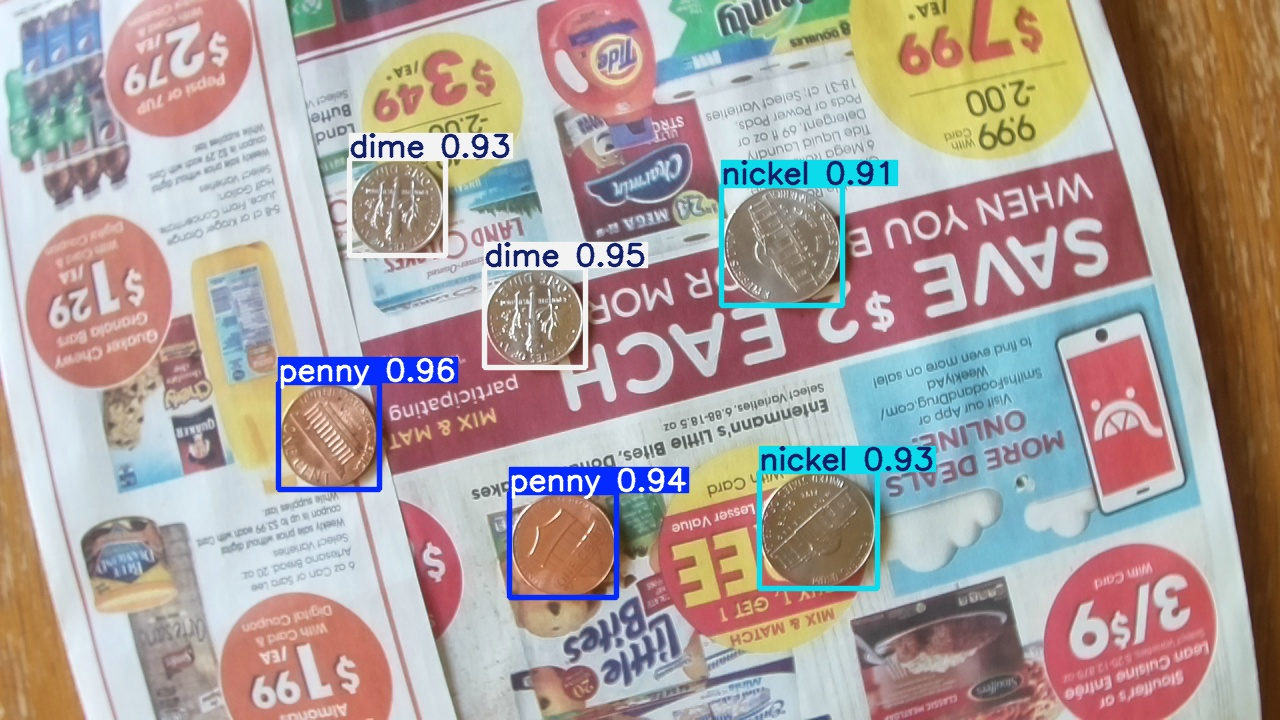

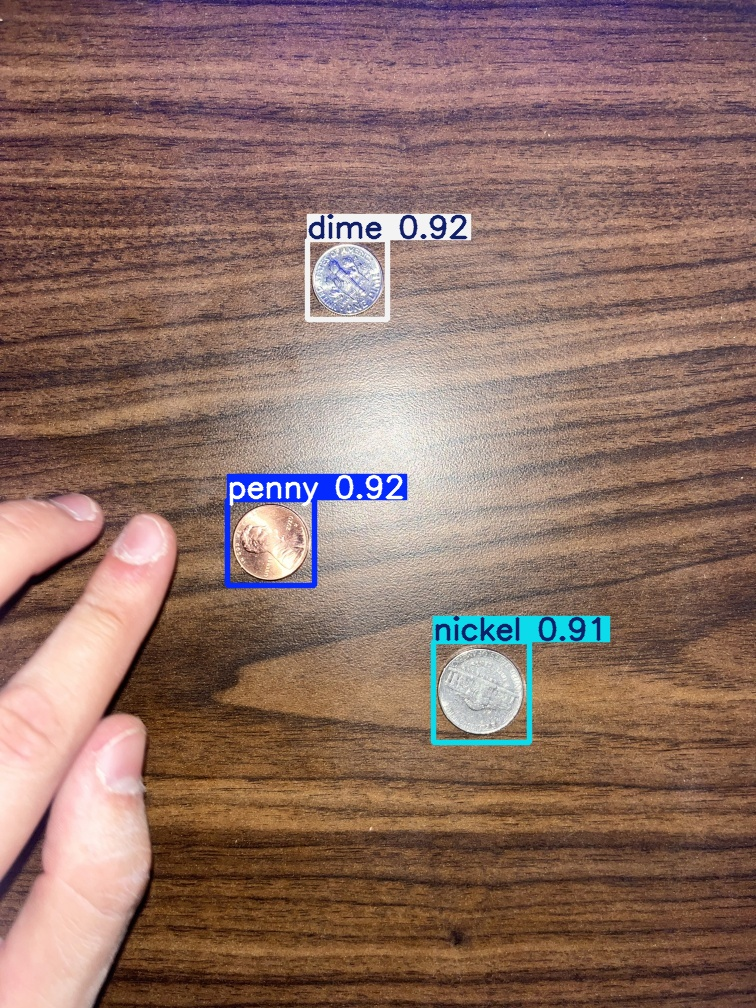

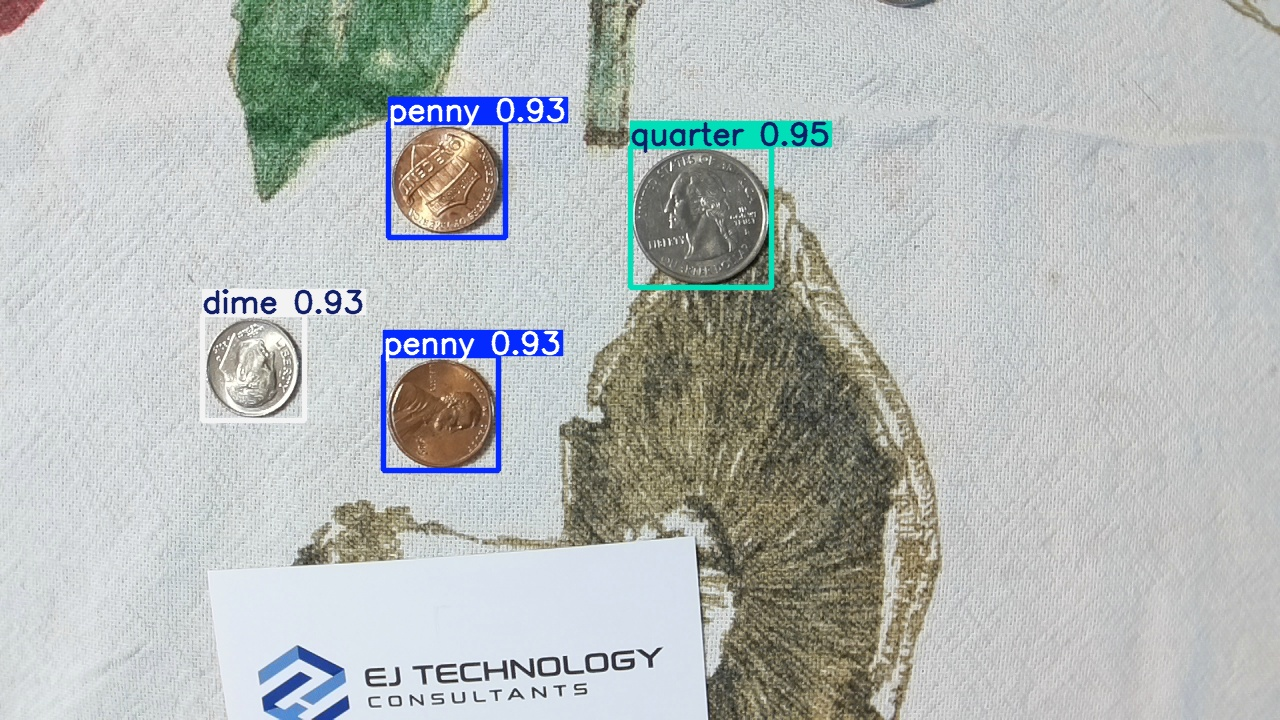

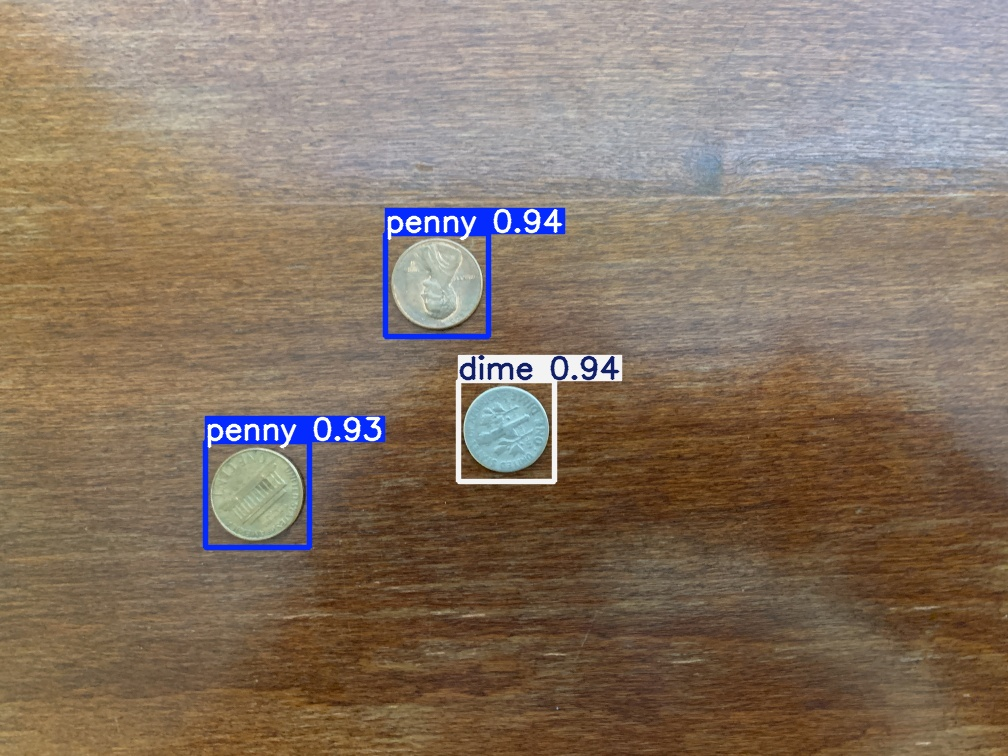

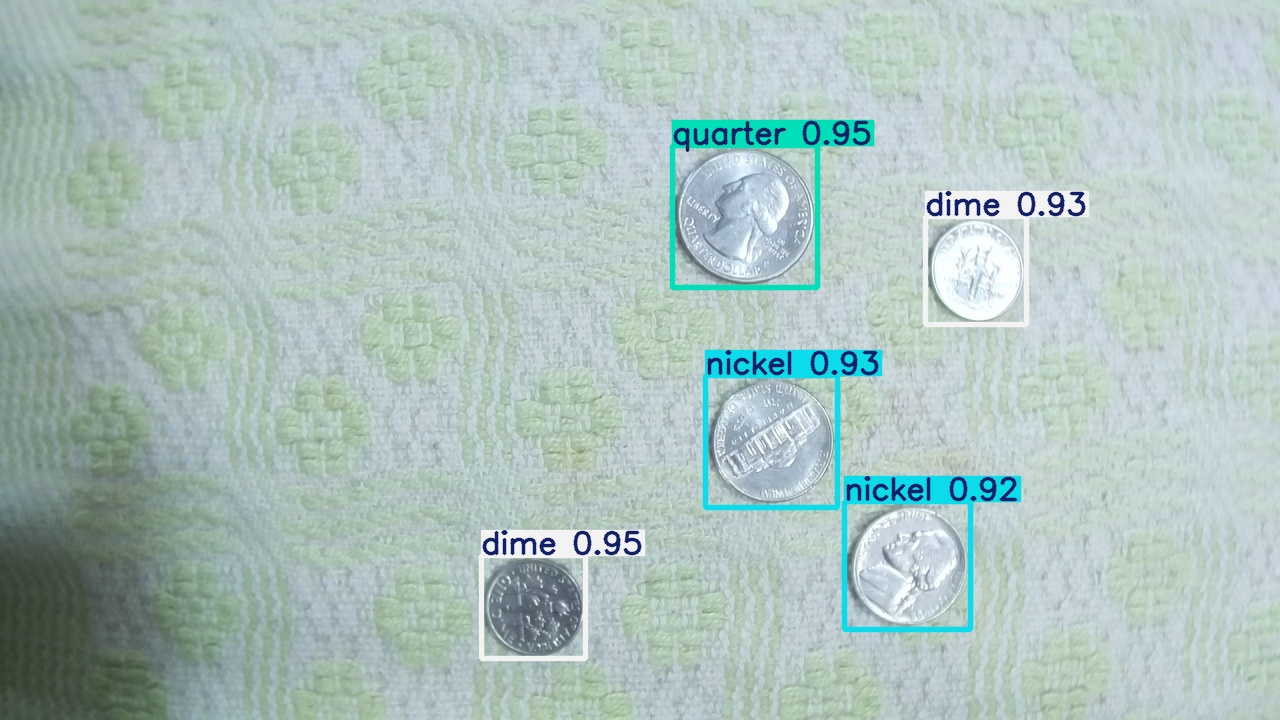

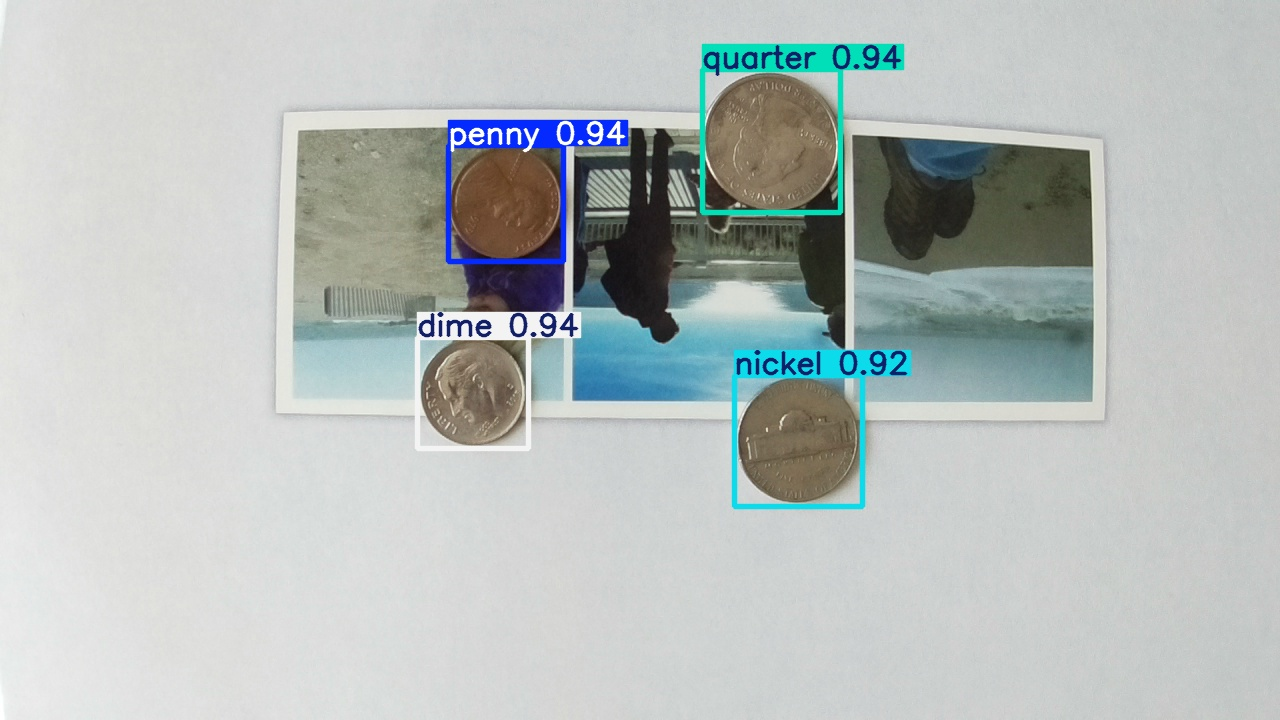

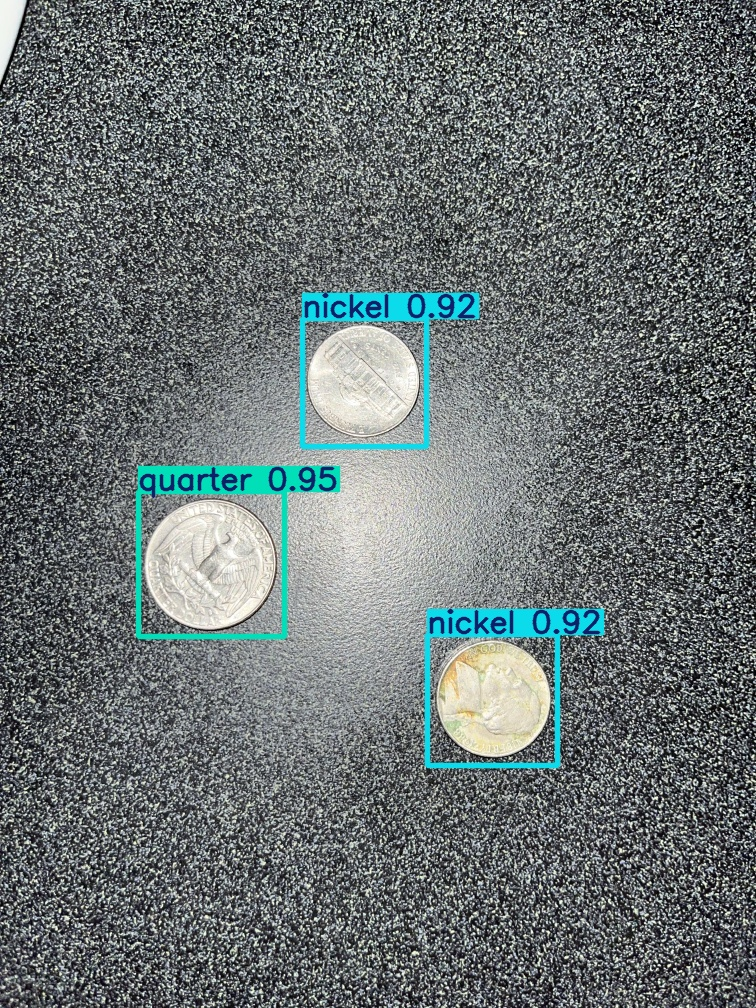

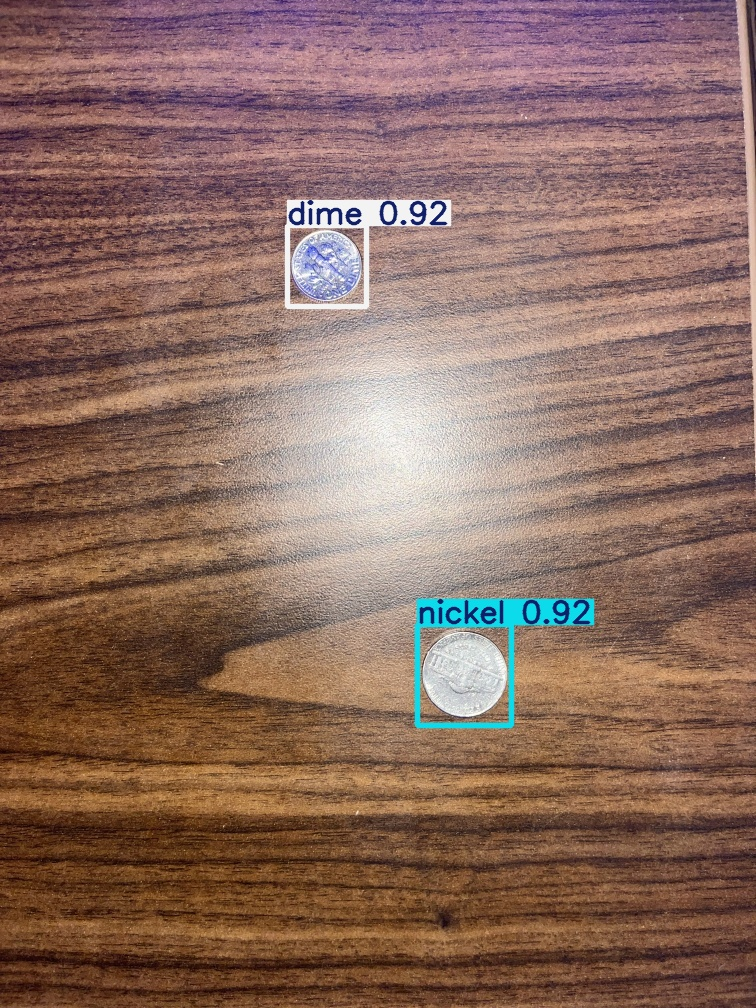

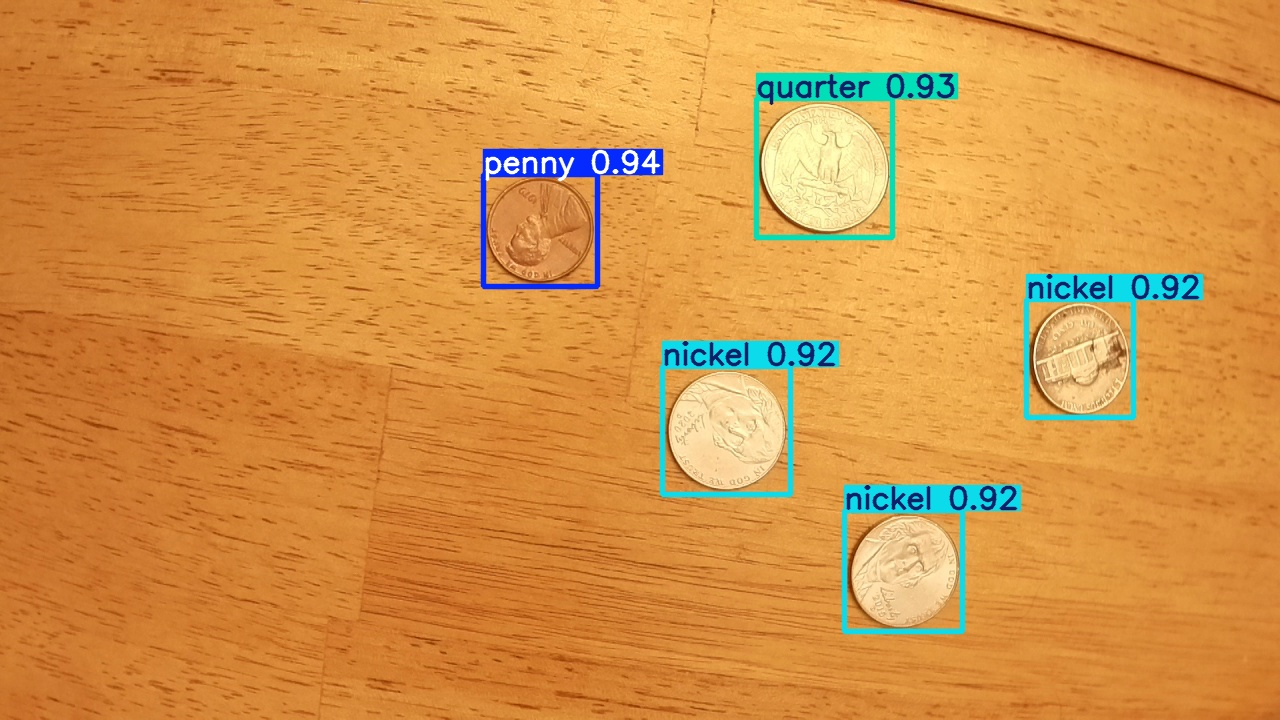

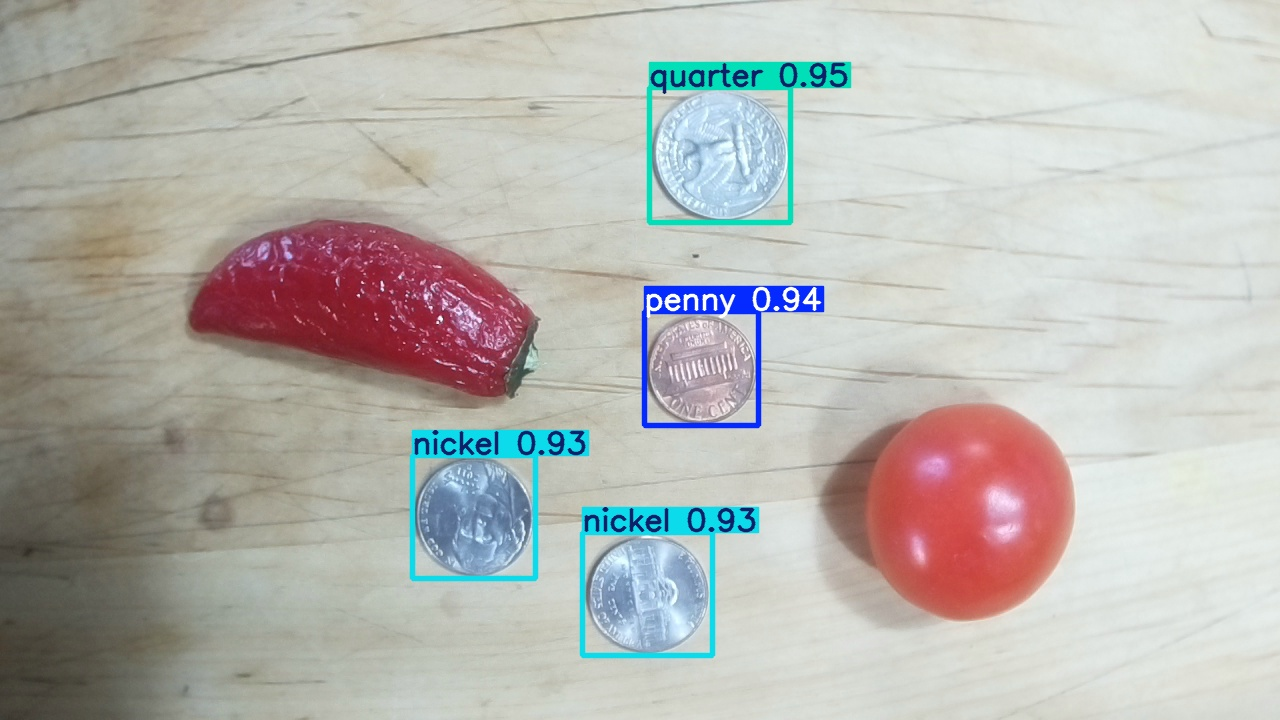

In [8]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


Inference & Deployment

The trained model successfully generated bounding boxes around detected objects in test images.

Additional predictions can be made on images or video files, with results saved under runs/detect/predict/.

The model weights (best.pt) can also be exported and used locally for real-time inference outside of Colab.

#&nbsp;Deploying Model

The trained weights (best.pt) were exported for use outside of Colab. YOLO models are lightweight and can be deployed on different platforms such as PCs, edge devices, or embedded systems. This makes the model suitable for integration into real-world applications, including object counting and monitoring tasks.

## Exporting the Model

The trained weights were saved as best.pt and then packaged along with the training results for easy sharing and deployment. A copy of the model (my_model.pt) was also created for direct use in inference tasks.

In [9]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/confusion_matrix.png (deflated 30%)
  adding: train/val_batch1_labels.jpg (deflated 11%)
  adding: train/train_batch0.jpg (deflated 5%)
  adding: train/train_batch2.jpg (deflated 4%)
  adding: train/labels.jpg (deflated 34%)
  adding: train/train_batch1.jpg (deflated 6%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/val_batch2_labels.jpg (deflated 6%)
  adding: train/val_batch2_pred.jpg (deflated 6%)
  adding: train/confusion_matrix_normalized.png (deflated 27%)
  adding: train/BoxP_curve.png (deflated 19%)
  adding: train/train_batch2151.jpg (deflated 8%)
  adding: train/val_batch0_labels.jpg (deflated 7%)
  adding: train/train_batch2152.jpg (deflated 9%)
  adding: train/results.png (deflated 8%)
  adding: train/train_batch2150.jpg (deflated 12%)
  adding: train/BoxPR_curve.png (deflated 23

In [10]:
# We can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Running the Model Locally

The trained YOLO model was tested on a local device using a simple Python script. The script loads the model, runs inference on sample images, and displays bounding boxes around detected objects. This provides a foundation for integrating the model into larger applications such as object monitoring or counting systems.

### Deployment on PC

The trained model was deployed locally on a PC. A Python script (yolo_detect.py) was used to load the model and run inference on images and video streams. The setup allowed real-time detection with bounding boxes displayed for each object. GPU acceleration (CUDA) can also be enabled for faster inference if supported.



# 8.&nbsp;Conclusion

A YOLO-based object detection model was successfully trained and deployed. The model demonstrates the ability to detect and classify objects accurately, and can be extended for applications such as object counting, monitoring, or logging detections over time. This project provides a foundation for applying YOLO to domain-specific datasets (e.g., waterbody or tree detection).